## Import library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

## Import dataset

In [2]:
 # EUR - VND
eur = pd.read_csv('EUR.csv')
 # GBP - VND
gbp = pd.read_csv("GBP.csv")
 # JPY - VND
jpy = pd.read_csv("JPY.csv")
# Convert
eur = eur['Sale'].replace({',':''}, regex=True).astype(float)
gbp = gbp['Sale'].replace({',':''}, regex=True).astype(float)
jpy = jpy['Sale'].replace({',':''}, regex=True).astype(float)

## Split train, test

In [3]:
# EUR - VND
  # case 1. 7:3
train_eur_1 = eur[:int(0.7*len(eur))]
test_eur_1 = eur[int(0.7*len(eur)):]
  # case 2. 8:2
train_eur_2 = eur[:int(0.8*len(eur))]
test_eur_2 = eur[int(0.8*len(eur)):]
  # case 3. 9:1
train_eur_3 = eur[:int(0.9*len(eur))]
test_eur_3 = eur[int(0.9*len(eur)):]

# GBP - VND
  # case 1. 7:3
train_gbp_1 = gbp[:int(0.7*len(gbp))]
test_gbp_1 = gbp[int(0.7*len(gbp)):]
  # case 2. 8:2
train_gbp_2 = gbp[:int(0.8*len(gbp))]
test_gbp_2 = gbp[int(0.8*len(gbp)):]
  # case 3. 9:1
train_gbp_3 = gbp[:int(0.9*len(gbp))]
test_gbp_3 = gbp[int(0.9*len(gbp)):]

# JPY - VND
  # case 1. 7:3
train_jpy_1 = jpy[:int(0.7*len(jpy))]
test_jpy_1 = jpy[int(0.7*len(jpy)):]
  # case 2. 8:2
train_jpy_2 = jpy[:int(0.8*len(jpy))]
test_jpy_2 = jpy[int(0.8*len(jpy)):]
  # case 3. 9:1
train_jpy_3 = jpy[:int(0.9*len(jpy))]
test_jpy_3 = jpy[int(0.9*len(jpy)):]

## Evaluate model

In [4]:
def accuracy(forecast, actual):
    forecast = np.array(forecast)
    actual = np.array(actual)
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))*100
    mae = np.mean(np.abs(forecast - actual))
    rmse = np.mean((forecast - actual)**2)**.5

    print('RMSE =',rmse)
    print('MAPE =',mape)
    print('MAE =',mae)

## ETS (Exponential Smoothing)

#### Find best smoothing level

In [5]:
alphas = np.linspace(0.1, 1.0, 10)  
alphas

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [6]:
mse_values = {}
def find_best_alpha (train, test):
    for alpha in alphas:
        model = ExponentialSmoothing(train, trend=None, seasonal=None).fit(smoothing_level = alpha)
        forecast = model.forecast(len(test))
        mse = mean_squared_error(test, forecast)
        mse_values[alpha] = mse
    best_alpha = min(mse_values, key=mse_values.get)
    print(f"Best smoothing factor chosen = {best_alpha:.1f}")
    return best_alpha

#### Build model

In [7]:
def build_model(data, alpha):
  model = ExponentialSmoothing(data, trend=None, seasonal=None).fit(smoothing_level = alpha)
  return model

#### Forecast 30,60,90 days

In [8]:
def forecast_days(train, predicted_test, alpha):
    train_predicted = np.concatenate([train, predicted_test])
    
    # Forecast next 30 days
    model_30 = build_model(train_predicted, alpha)
    forecast30 = model_30.forecast(steps=30)
    train_predicted_30 = np.concatenate([train_predicted, forecast30])
    
    # Forecast the next 60 days
    model_60 = build_model(train_predicted_30, alpha)
    forecast60 = model_60.forecast(steps=30)
    train_predicted_60 = np.concatenate([train_predicted_30, forecast60])
    
    # Forecast the next 90 days
    model_90 = build_model(train_predicted_60, alpha)
    forecast90 = model_90.forecast(steps=30)
    
    return forecast30, forecast60, forecast90

#### Predict test data

In [9]:
# Define function predict next 30, 60, 90 days
def predict_data_ETS(model, train, test, alpha):
  pre_test = model.predict(start=len(train), end=len(train) + len(test) - 1)
  forecast30, forecast60, forecast90 = forecast_days(train, pre_test, alpha)
  return pre_test, forecast30, forecast60, forecast90

#### Visualize data

In [10]:
def visualise_ETS_model(train, test, pre_test, f30, f60, f90):
    plt.figure(figsize=(12, 6))

    start_date = pd.to_datetime('3/1/2019')
    end_date = pd.to_datetime('6/1/2024')
    start_date_fc = pd.to_datetime('6/2/2024')

    index = pd.date_range(start=start_date, end=end_date, freq='D')
    forecast_index = pd.date_range(start=start_date_fc, periods=90, freq='D')

    unique_years = index.year.unique()
    x_ticks = [pd.to_datetime(str(year)) for year in unique_years]
    
    plt.xticks(x_ticks, unique_years)    

    train_index = index[:len(train)]
    test_index = index[len(train): len(train) + len(test)]
    
    f30_index = forecast_index[:30]
    f60_index = forecast_index[30:60]
    f90_index = forecast_index[60:]

    plt.plot(train_index, train, label='Train', color='blue')
    plt.plot(test_index, test, label='Actual Test', color='orange')
    plt.plot(test_index, pre_test, label='Prediction Test', color='green')

    plt.plot(f30_index, f30, label='Forecast next 30 days', color='red')
    plt.plot(f60_index, f60, label='Forecast next 60 days', color='purple')
    plt.plot(f90_index, f90, label='Forecast next 90 days', color='pink')
    
    plt.title('ETS Time Series Forecast')
    plt.xlabel('Date')
    plt.ylabel('Exchange Rate (VND)')
    plt.legend()
    
    plt.show()

#### EUR_VND

* Case 7:3

In [11]:
alpha_eur_1 = find_best_alpha(train_eur_1, test_eur_1)
model_eur_1 = build_model(train_eur_1, alpha_eur_1)

Best smoothing factor chosen = 0.3


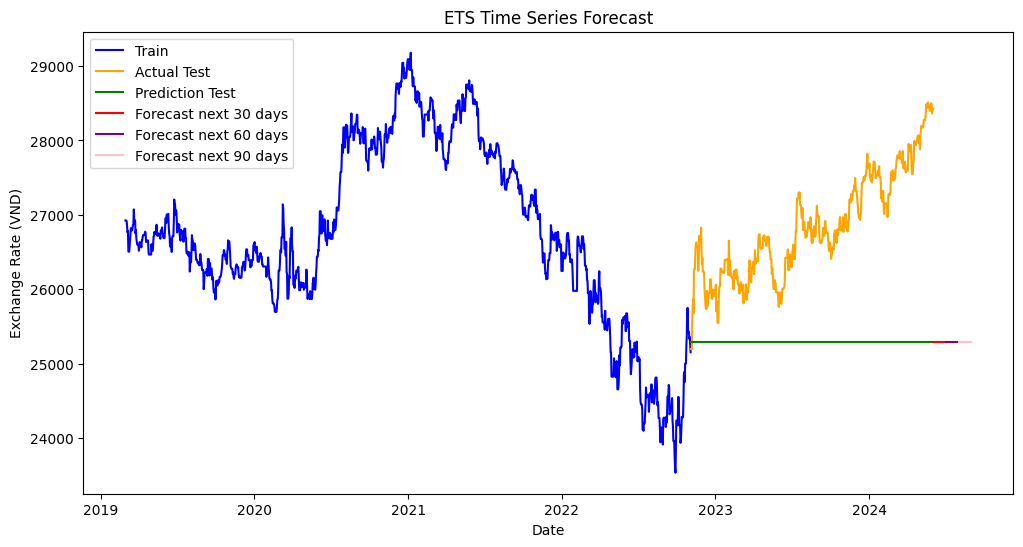

Model accuracy (EUR - 7:3)
RMSE = 1704.9335904570712
MAPE = 5.715056861861526
MAE = 1551.4199389763303


In [12]:
predict_test_eur_1, forecast_eur_1_30, forecast_eur_1_60, forecast_eur_1_90 = predict_data_ETS(model_eur_1, train_eur_1, test_eur_1, alpha_eur_1)
visualise_ETS_model(train_eur_1,test_eur_1,predict_test_eur_1,forecast_eur_1_30, forecast_eur_1_60, forecast_eur_1_90)

print('Model accuracy (EUR - 7:3)')
accuracy(predict_test_eur_1, test_eur_1)

* Case 8:2

In [13]:
alpha_eur_2 = find_best_alpha(train_eur_2, test_eur_2)
model_eur_2 = build_model(train_eur_2, alpha_eur_2)

Best smoothing factor chosen = 0.1


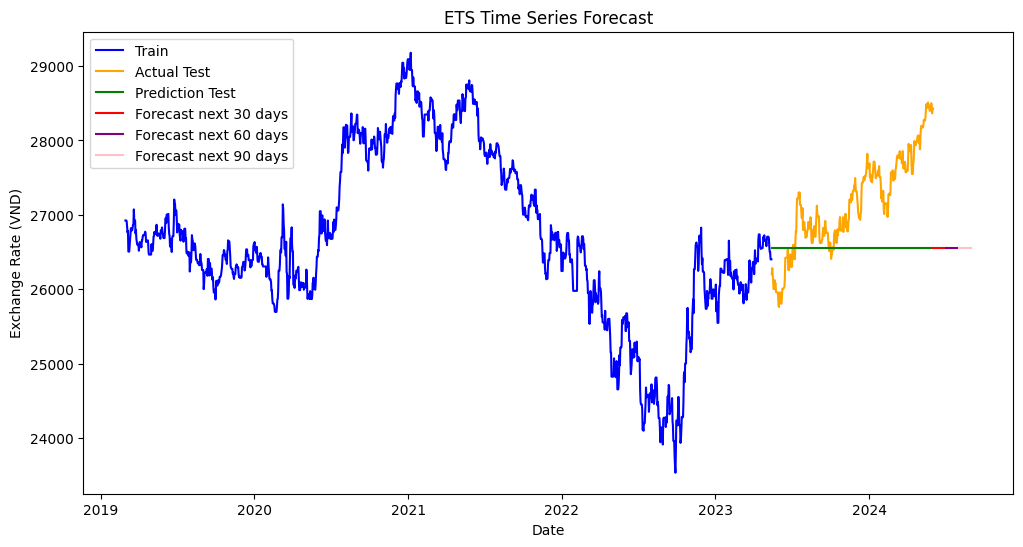

Model accuracy (EUR - 8:2)
RMSE = 877.386434370238
MAPE = 2.5999558641841096
MAE = 715.8069516245956


In [14]:
predict_test_eur_2, forecast_eur_2_30, forecast_eur_2_60, forecast_eur_2_90 = predict_data_ETS(model_eur_2, train_eur_2, test_eur_2, alpha_eur_2)
visualise_ETS_model(train_eur_2,test_eur_2,predict_test_eur_2,forecast_eur_2_30, forecast_eur_2_60, forecast_eur_2_90)

print('Model accuracy (EUR - 8:2)')
accuracy(predict_test_eur_2, test_eur_2)

* Case 9:1

In [15]:
alpha_eur_3 = find_best_alpha(train_eur_3, test_eur_3)
model_eur_3 = build_model(train_eur_3, alpha_eur_3)

Best smoothing factor chosen = 0.5


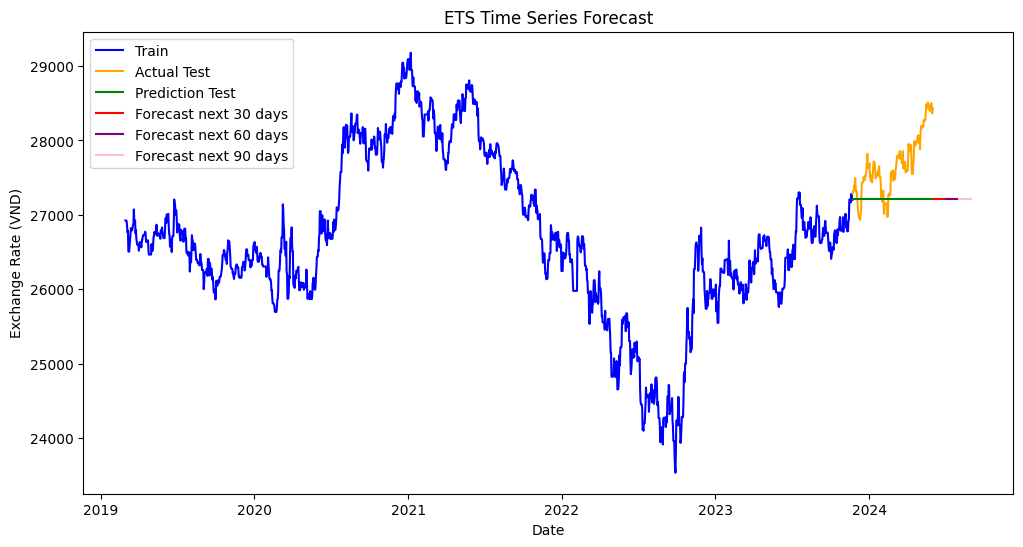

Model accuracy (EUR - 9:1)
RMSE = 596.9217846112217
MAPE = 1.7414967189948944
MAE = 486.41687258533733


In [16]:
predict_test_eur_3, forecast_eur_3_30, forecast_eur_3_60, forecast_eur_3_90 = predict_data_ETS(model_eur_3, train_eur_3, test_eur_3, alpha_eur_3)
visualise_ETS_model(train_eur_3,test_eur_3,predict_test_eur_3,forecast_eur_3_30, forecast_eur_3_60, forecast_eur_3_90)

print('Model accuracy (EUR - 9:1)')
accuracy(predict_test_eur_3, test_eur_3)

#### JPY_VND

* Case 7:3

In [17]:
alpha_jpy_1 = find_best_alpha(train_jpy_1, test_jpy_1)
model_jpy_1 = build_model(train_jpy_1, alpha_jpy_1)

Best smoothing factor chosen = 0.3


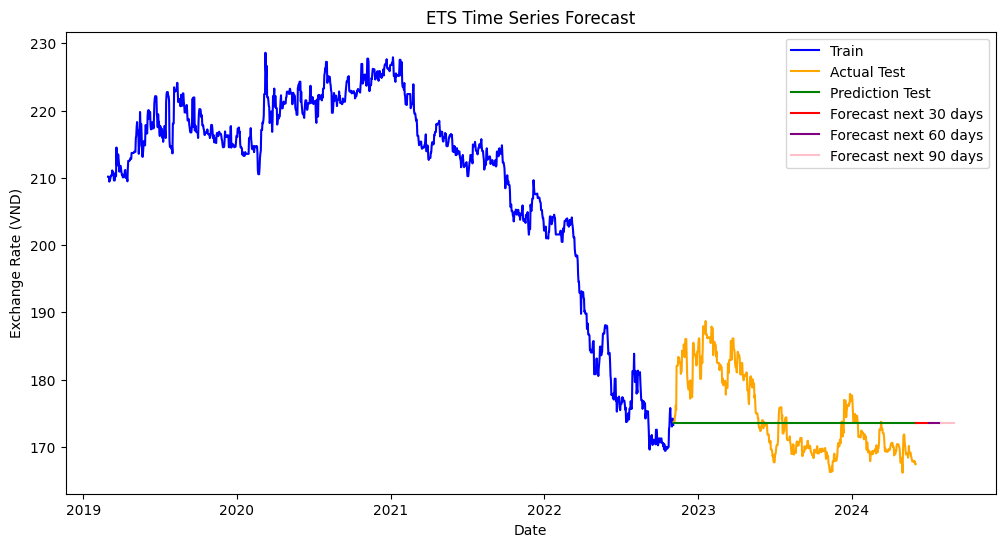

Model accuracy (JPY - 7:3)
RMSE = 6.1314650292474715
MAPE = 2.8858455711143054
MAE = 5.114456933464677


In [18]:
predict_test_jpy_1, forecast_jpy_1_30, forecast_jpy_1_60, forecast_jpy_1_90 = predict_data_ETS(model_jpy_1, train_jpy_1, test_jpy_1, alpha_jpy_1)
visualise_ETS_model(train_jpy_1,test_jpy_1,predict_test_jpy_1,forecast_jpy_1_30, forecast_jpy_1_60, forecast_jpy_1_90)

print('Model accuracy (JPY - 7:3)')
accuracy(predict_test_jpy_1, test_jpy_1)

* Case 8:2

In [19]:
alpha_jpy_2 = find_best_alpha(train_jpy_2, test_jpy_2)
model_jpy_2 = build_model(train_jpy_2, alpha_jpy_2)

Best smoothing factor chosen = 1.0


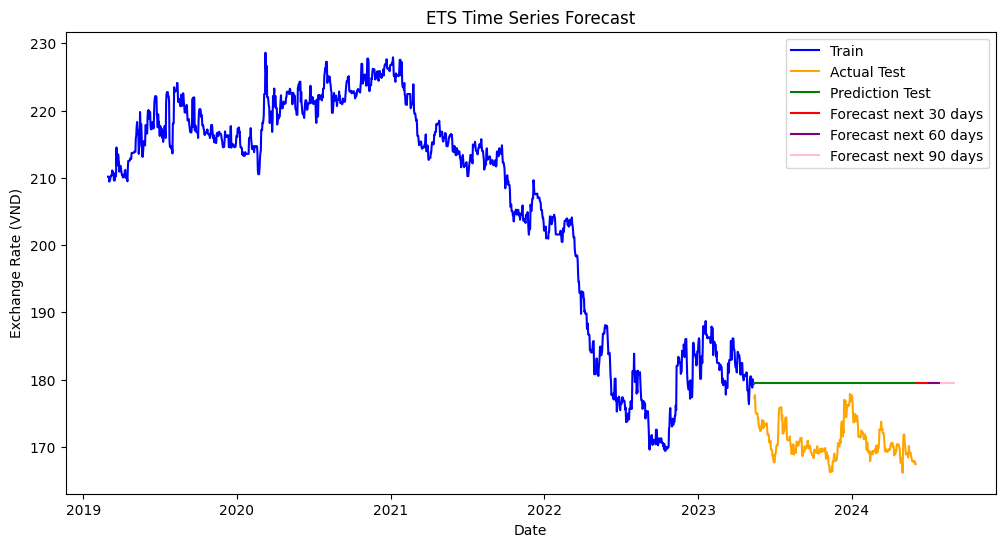

Model accuracy (JPY - 8:2)
RMSE = 8.94075360358399
MAPE = 5.044827820209882
MAE = 8.580729166666673


In [20]:
predict_test_jpy_2, forecast_jpy_2_30, forecast_jpy_2_60, forecast_jpy_2_90 = predict_data_ETS(model_jpy_2, train_jpy_2, test_jpy_2, alpha_jpy_2)
visualise_ETS_model(train_jpy_2,test_jpy_2,predict_test_jpy_2,forecast_jpy_2_30, forecast_jpy_2_60, forecast_jpy_2_90)

print('Model accuracy (JPY - 8:2)')
accuracy(predict_test_jpy_2, test_jpy_2)

* Case 9:1

In [21]:
alpha_jpy_3 = find_best_alpha(train_jpy_3, test_jpy_3)
model_jpy_3 = build_model(train_jpy_3, alpha_jpy_3)

Best smoothing factor chosen = 0.5


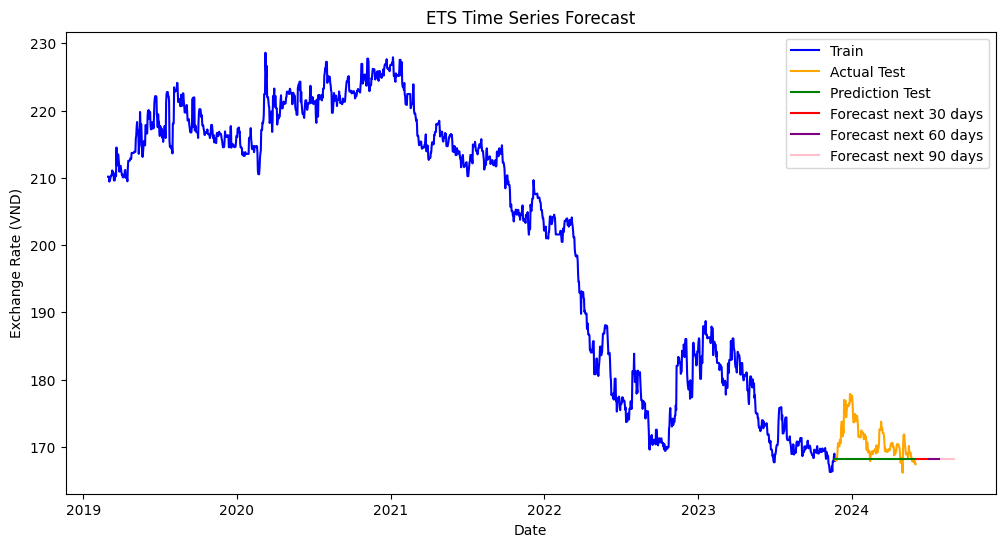

Model accuracy (JPY - 9:1)
RMSE = 3.8080238572118263
MAPE = 1.654103016607778
MAE = 2.86544349810444


In [22]:
predict_test_jpy_3, forecast_jpy_3_30, forecast_jpy_3_60, forecast_jpy_3_90 = predict_data_ETS(model_jpy_3, train_jpy_3, test_jpy_3, alpha_jpy_3)
visualise_ETS_model(train_jpy_3,test_jpy_3,predict_test_jpy_3,forecast_jpy_3_30, forecast_jpy_3_60, forecast_jpy_3_90)

print('Model accuracy (JPY - 9:1)')
accuracy(predict_test_jpy_3, test_jpy_3)

#### GBP_VND

* Case 7:3

In [23]:
alpha_gbp_1 = find_best_alpha(train_gbp_1, test_gbp_1)
model_gbp_1 = build_model(train_gbp_1, alpha_gbp_1)

Best smoothing factor chosen = 0.3


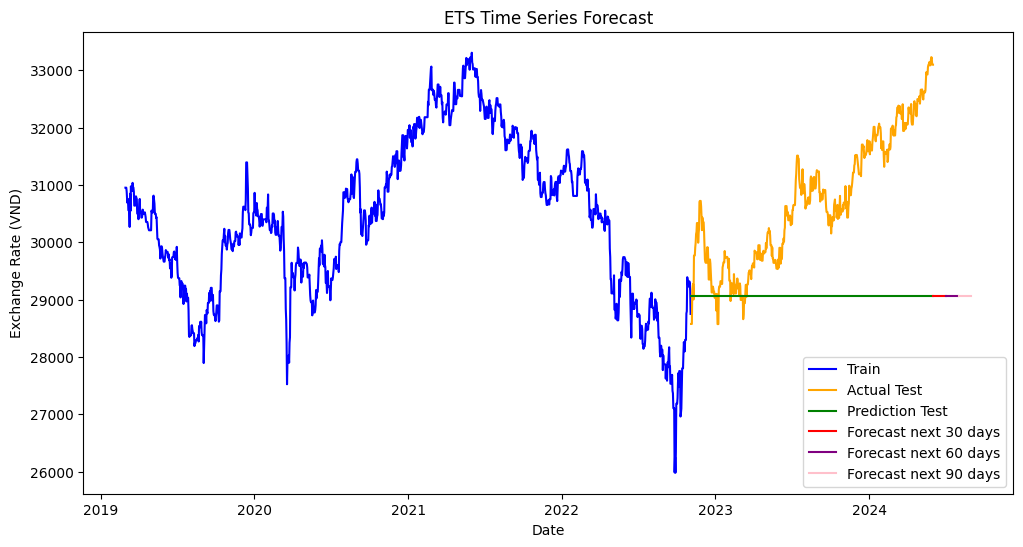

Model accuracy (GBP - 7:3)
RMSE = 2001.1461048360172
MAPE = 5.331803600851459
MAE = 1675.1682631439758


In [24]:
predict_test_gbp_1, forecast_gbp_1_30, forecast_gbp_1_60, forecast_gbp_1_90 = predict_data_ETS(model_gbp_1, train_gbp_1, test_gbp_1, alpha_gbp_1)
visualise_ETS_model(train_gbp_1,test_gbp_1,predict_test_gbp_1,forecast_gbp_1_30, forecast_gbp_1_60, forecast_gbp_1_90)

print('Model accuracy (GBP - 7:3)')
accuracy(predict_test_gbp_1, test_gbp_1)

* Case 8:2

In [25]:
alpha_gbp_2 = find_best_alpha(train_gbp_2, test_gbp_2)
model_gbp_2 = build_model(train_gbp_2, alpha_gbp_2)

Best smoothing factor chosen = 0.2


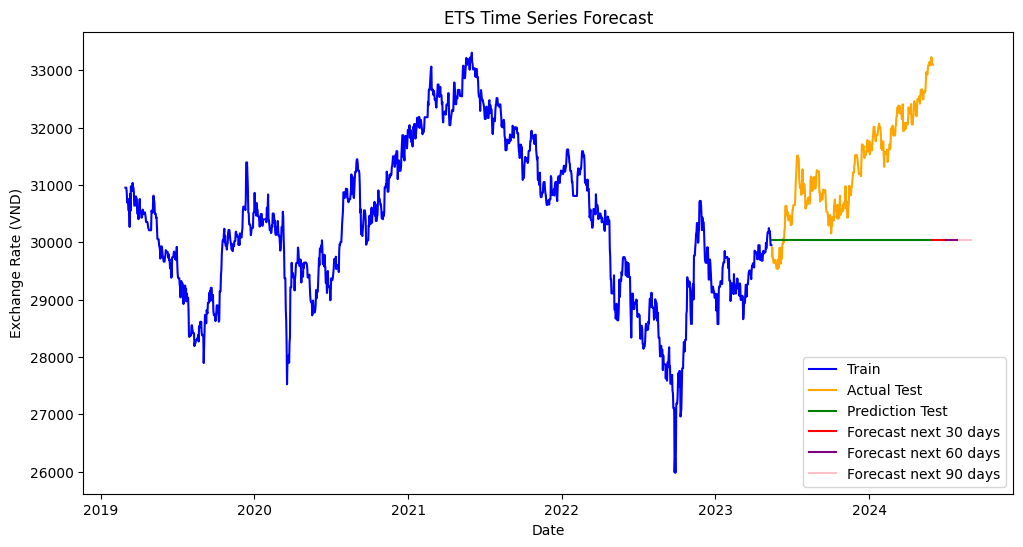

Model accuracy (GBP - 8:2)
RMSE = 1536.6126034610945
MAPE = 4.133977194910197
MAE = 1314.562834725818


In [26]:
predict_test_gbp_2, forecast_gbp_2_30, forecast_gbp_2_60, forecast_gbp_2_90 = predict_data_ETS(model_gbp_2, train_gbp_2, test_gbp_2, alpha_gbp_2)
visualise_ETS_model(train_gbp_2,test_gbp_2,predict_test_gbp_2,forecast_gbp_2_30, forecast_gbp_2_60, forecast_gbp_2_90)

print('Model accuracy (GBP - 8:2)')
accuracy(predict_test_gbp_2, test_gbp_2)

* Case 9:1

In [27]:
alpha_gbp_3 = find_best_alpha(train_gbp_3, test_gbp_3)
model_gbp_3 = build_model(train_gbp_3, alpha_gbp_3)

Best smoothing factor chosen = 1.0


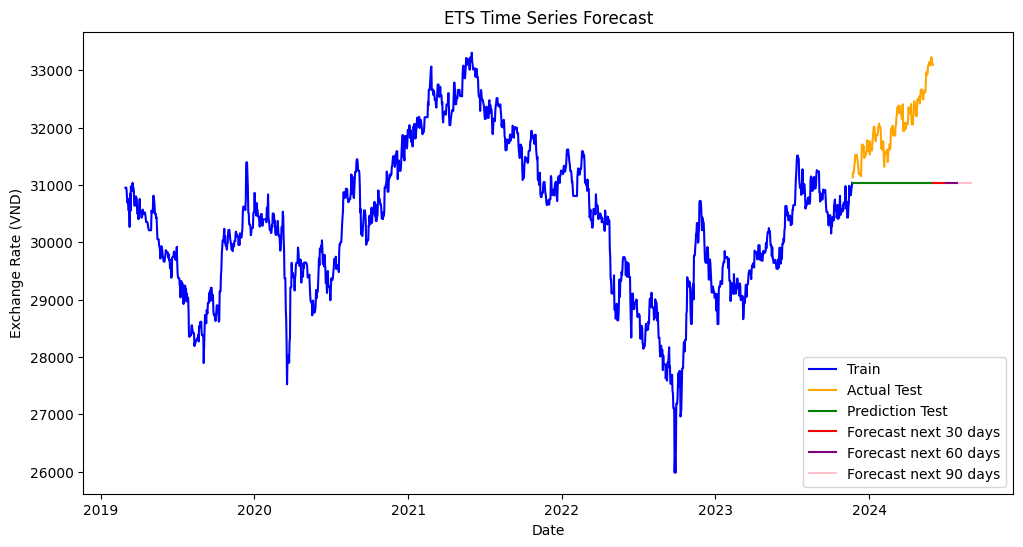

Model accuracy (GBP - 9:1)
RMSE = 1112.536073853338
MAPE = 3.0707601316283863
MAE = 991.1197916666666


In [28]:
predict_test_gbp_3, forecast_gbp_3_30, forecast_gbp_3_60, forecast_gbp_3_90 = predict_data_ETS(model_gbp_3, train_gbp_3, test_gbp_3, alpha_gbp_3)
visualise_ETS_model(train_gbp_3,test_gbp_3,predict_test_gbp_3,forecast_gbp_3_30, forecast_gbp_3_60, forecast_gbp_3_90)

print('Model accuracy (GBP - 9:1)')
accuracy(predict_test_gbp_3, test_gbp_3)